In [ ]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from collections import Counter
import networkx as nx
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_filled_oct = pd.read_csv('/content/drive/MyDrive/ecommerceDataset/clean_filled_oct.csv')

df_filled_nov = pd.read_csv('/content/drive/MyDrive/ecommerceDataset/clean_filled_nov.csv')

In [ ]:
# Combine the datasets
df_combined = pd.concat([df_filled_oct, df_filled_nov], ignore_index=True)
df_combined['event_time'] = pd.to_datetime(df_combined['event_time'])
df_combined.head()



,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00+00:00,view,44600062,2103807459595387724,unknown_category,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00+00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01+00:00,view,17200506,2053013559792632471,furniture.living_room.sofa,rals,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01+00:00,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04+00:00,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [ ]:
#Sample 5% of unique users (after combining Oct + Nov)
print("Sampling 5% of users to make the dataset manageable...")

sample_users = np.random.choice(
    df_combined['user_id'].unique(),
    size=int(0.05 * df_combined['user_id'].nunique()),
    replace=False
)

# Filter the combined dataset for only those sampled users
df_combined = df_combined[df_combined['user_id'].isin(sample_users)].copy()
df_combined.reset_index(drop=True, inplace=True)

print(f"Sampled dataset shape: {df_combined.shape}")



Sampling 5% of users to make the dataset manageable...
Sampled dataset shape: (5495190, 9)


In [ ]:
# Convert event_time to datetime
df_combined['event_time'] = pd.to_datetime(df_combined['event_time'])

In [ ]:
#Create User-Level Features
user_df = df_combined.groupby('user_id').agg(
    total_views=('event_type', lambda x: (x == 'view').sum()),
    total_cart_adds=('event_type', lambda x: (x == 'cart').sum()),
    total_purchases=('event_type', lambda x: (x == 'purchase').sum()),
    total_spent=('price', lambda x: x[df_combined.loc[x.index, 'event_type'] == 'purchase'].sum()),
    avg_price_viewed=('price', lambda x: x[df_combined.loc[x.index, 'event_type'] == 'view'].mean()),
    sessions_count=('user_session', pd.Series.nunique),
    unique_categories=('category_code', pd.Series.nunique),
    first_seen=('event_time', 'min'),
    last_seen=('event_time', 'max')
).reset_index()


In [ ]:
# Add Time Features
latest_time = df_combined['event_time'].max()
user_df['recency_days'] = (latest_time - user_df['last_seen']).dt.days
user_df['active_days'] = (user_df['last_seen'] - user_df['first_seen']).dt.days + 1
user_df = user_df.fillna(0)


In [ ]:
#Select and Scale Features
features = ['total_views', 'total_cart_adds', 'total_purchases', 'total_spent',
            'avg_price_viewed', 'sessions_count', 'unique_categories',
            'recency_days', 'active_days']

X = user_df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


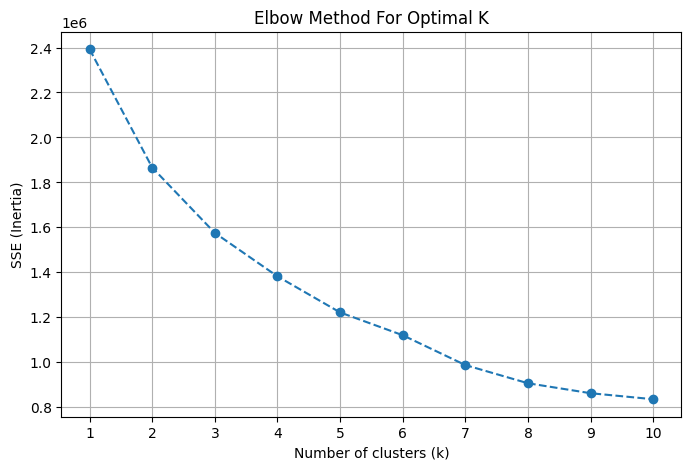

In [ ]:
#Elbow Method for Optimal K
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.xticks(k_range)
plt.grid(True)
plt.show()


In [ ]:
#K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
user_df['cluster'] = kmeans.fit_predict(X_scaled)

#STEP 8: Cluster Summary
cluster_summary = user_df.groupby('cluster')[features].mean().round(2)
print(cluster_summary)


         total_views  total_cart_adds  total_purchases  total_spent  \
cluster                                                               
0              35.02             1.17             0.45       123.00   
1               6.03             0.22             0.10        28.72   
2             198.55             7.88             3.03       841.63   
3             227.79            38.97            29.90     12951.60   

         avg_price_viewed  sessions_count  unique_categories  recency_days  \
cluster                                                                      
0                  303.45            7.68               4.01          9.35   
1                  312.99            1.89               1.41         26.45   
2                  290.26           31.24               9.81          6.19   
3                  469.48           47.61               8.25          7.00   

         active_days  
cluster               
0              35.16  
1               3.36  
2           

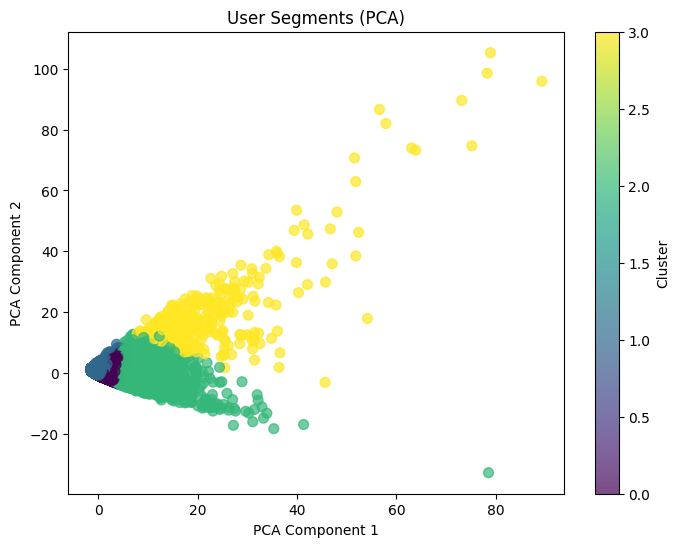

In [ ]:
#PCA for Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot (Basic)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=user_df['cluster'], cmap='viridis', s=50, alpha=0.7)
plt.title("User Segments (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


In [ ]:
segment_labels = {
    0: 'Window Shoppers',
    1: 'Inactive Users',
    2: 'Active Buyers',
    3: 'VIP Buyers'
}
user_df['segment'] = user_df['cluster'].map(segment_labels)


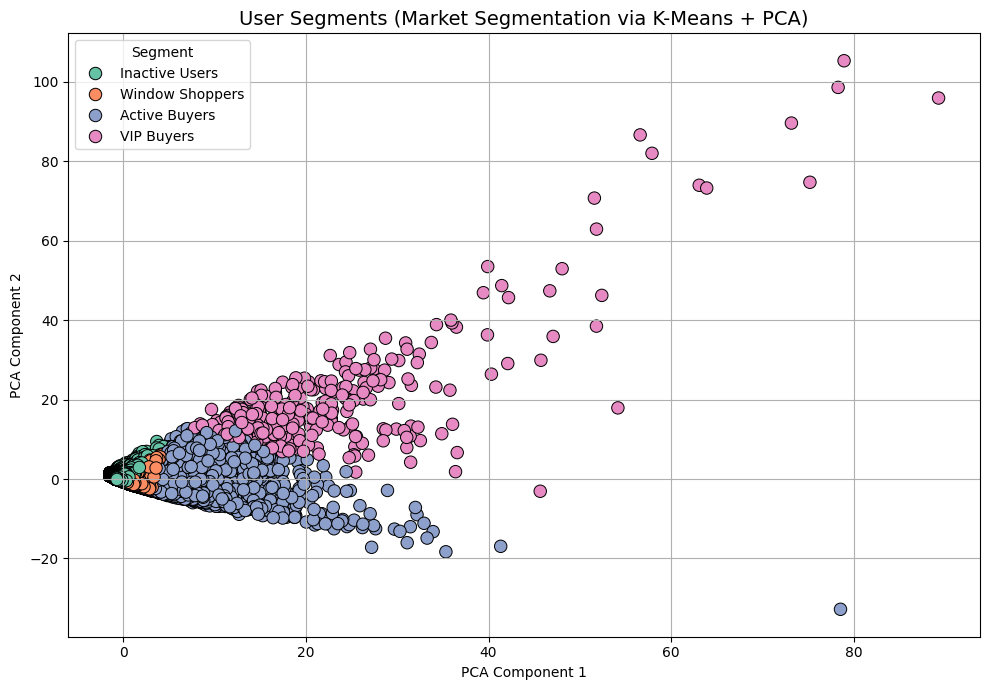

In [ ]:
# Final Visualization with Labels
pca_df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'Segment': user_df['segment']
})

plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Segment', palette='Set2', s=80, edgecolor='black')
plt.title('User Segments (Market Segmentation via K-Means + PCA)', fontsize=14)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Segment', loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
user_df['cluster'] = kmeans.fit_predict(X_scaled)

#STEP 8: Cluster Summary
cluster_summary = user_df.groupby('cluster')[features].mean().round(2)
print(cluster_summary)


         total_views  total_cart_adds  total_purchases  total_spent  \
cluster                                                               
0              36.50             1.20             0.46       115.41   
1               6.25             0.22             0.10        19.29   
2             202.28             8.10             3.13       868.57   
3             226.93            39.38            30.38     13210.96   
4               6.25             0.28             0.12       109.76   

         avg_price_viewed  sessions_count  unique_categories  recency_days  \
cluster                                                                      
0                  282.73            7.91               4.13          9.17   
1                  194.16            1.91               1.44         26.25   
2                  290.55           31.71               9.86          6.14   
3                  472.74           47.73               8.25          6.99   
4                  990.10         

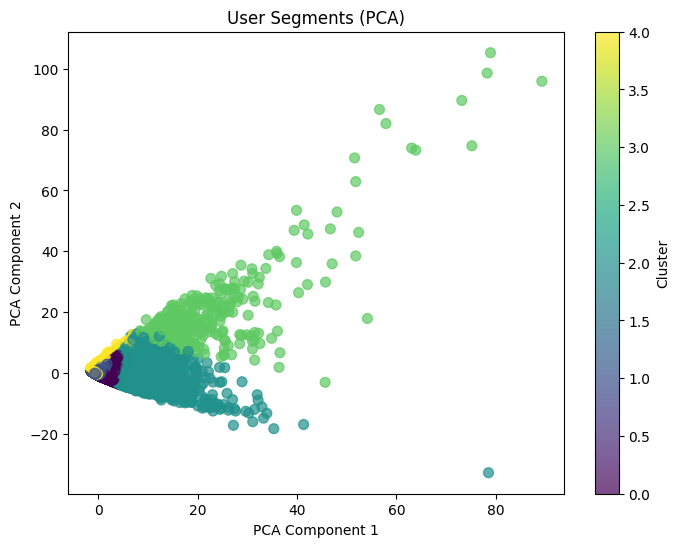

In [ ]:
#PCA for Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot (Basic)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=user_df['cluster'], cmap='viridis', s=50, alpha=0.7)
plt.title("User Segments (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()

In [ ]:
# Updated Segment Labels for 5 Clusters
segment_labels = {
    0: 'Active Buyers',       # Moderate purchases and engagement
    1: 'Inactive Users',      # Very low activity
    2: 'Smart Shoppers',      # High views, decent purchases and spend
    3: 'VIP Buyers',          # High purchases, spend, and sessions
    4: 'Price Explorers'      # Low activity but very high avg_price_viewed
}

# Apply the segment labels to the DataFrame
user_df['segment'] = user_df['cluster'].map(segment_labels)


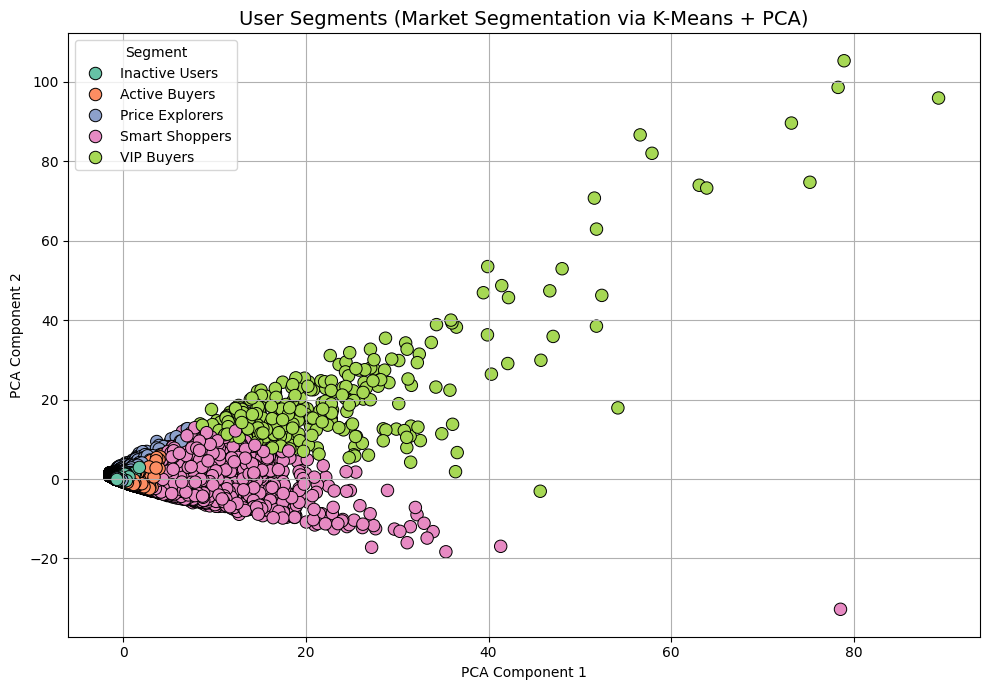

In [ ]:
# Final Visualization with Labels
pca_df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'Segment': user_df['segment']
})

plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Segment', palette='Set2', s=80, edgecolor='black')
plt.title('User Segments (Market Segmentation via K-Means + PCA)', fontsize=14)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Segment', loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()